In [6]:
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import transforms
import torchvision
import torch
from collections import defaultdict
import os
from skimage import exposure
from skimage import io

from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import glob
from PIL import Image

In [2]:
DEVICE = "cuda:3"

In [12]:
LABEL_ENCODING = {
    "NORMAL": 0,
    "PNEUMONIA": 1
}

class CXR_Dataset(torch.utils.data.Dataset):
    """
        Class for loading the images and their corresponding labels.
        Parameters:
        image_path (python list): A list contsisting of all the image paths (Normal and Pneunomina combined)
        transform (callable): Data augmentation pipeline.
    """
    def __init__(
        self,
        image_paths,
        transforms=None,
    ):
        super().__init__()
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        try:
            # Reading the image path and the corresponding label
            img_path = self.image_paths[item]
            label = self.image_paths[item].split('/')[-2] # Splitting the string and extracting the labels (the directory name in our case)
            label = torch.tensor(LABEL_ENCODING[label])
            # Opening the image using Pillow and resizing it to the required size
            img = Image.open(img_path).convert("L").resize((256, 256))
            img = np.array(img)
            
            # performing Histogram equalization on the Image to utilize the entire pixel range
            img = exposure.equalize_hist(img)
            
            img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8) 
            
            # Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
            img = np.stack((img, )*3) 
            img = np.transpose(img, (1, 2, 0))
            
            # Performing data augmentation using the transforms pipeline
            img = self.transforms(img)
            return {"img": img, "target": label}

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [13]:
def inference(
    model,
    dataloader,
):
    preds = []
    images = []
    gt = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Inference"):
            image = batch["img"].to(DEVICE)
            targets = batch["target"].to(DEVICE)
            y_preds = model(image)
            y_preds = torch.softmax(y_preds, dim=1)
            y_preds = torch.argmax(y_preds, dim=1)
            preds.append(y_preds.cpu())
            images.append(image.cpu())
            gt.append(targets.cpu())
            
    return images, preds, gt

In [14]:
test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [18]:
test_images = glob.glob('../data/chest_xray/test/*/*.jpeg')

DENSENET121 = torchvision.models.densenet121()
DENSENET121.classifier = nn.Sequential(
        nn.Linear(in_features=(DENSENET121.classifier.in_features),out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512,out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256,out_features=128),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128,out_features=2)
    )


model = DENSENET121
model = model.to(DEVICE)
model_config = torch.load('../models/V0/densenet121/2023-06-30 10:50:46.047269/best_model_config.pth.tar', map_location='cuda:3')
model.load_state_dict(model_config['model_weights'])

test_images = np.random.choice(test_images, size=len(test_images))

dataset = CXR_Dataset(test_images, test_transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=32)

inputs, outputs, gts = inference(model, dataloader)

'''for i in range(2):
    for j in range(64):
        img = inputs[i][j]
        pred = "Pneumonia" if outputs[i][j].item() == 1 else "Normal"
        gt = "Pneumonia" if gts[i][j].item() == 1 else "Normal"
        img_arr = np.array(torch.permute(img, (1, 2, 0)))
        plt.figure(figsize=(5, 5))
        plt.imshow(img_arr[:, :, 0], cmap="gray")
        plt.title(f"pred: {pred} | gt: {gt}")
        plt.axis("off")
        plt.show()'''

Inference: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


'for i in range(2):\n    for j in range(64):\n        img = inputs[i][j]\n        pred = "Pneumonia" if outputs[i][j].item() == 1 else "Normal"\n        gt = "Pneumonia" if gts[i][j].item() == 1 else "Normal"\n        img_arr = np.array(torch.permute(img, (1, 2, 0)))\n        plt.figure(figsize=(5, 5))\n        plt.imshow(img_arr[:, :, 0], cmap="gray")\n        plt.title(f"pred: {pred} | gt: {gt}")\n        plt.axis("off")\n        plt.show()'

In [30]:
f_list = []

for i in range(10):
    for j in range(64):
        try:
            pred = outputs[i][j]
            if pred.item() == 1:
                f_list.append("PNEUMONIA")

            if pred.item() == 0:
                f_list.append("NORMAL")
        except:
            break

In [31]:
len(f_list)

624

In [32]:
df = pd.DataFrame()
df['image_path'] = test_images
df['preds'] = f_list
df

,image_path,preds
0,../data/chest_xray/test/NORMAL/NORMAL2-IM-0280...,NORMAL
1,../data/chest_xray/test/PNEUMONIA/person131_ba...,PNEUMONIA
2,../data/chest_xray/test/PNEUMONIA/person87_bac...,PNEUMONIA
3,../data/chest_xray/test/NORMAL/NORMAL2-IM-0340...,NORMAL
4,../data/chest_xray/test/NORMAL/NORMAL2-IM-0315...,PNEUMONIA
...,...,...
619,../data/chest_xray/test/NORMAL/NORMAL2-IM-0353...,NORMAL
620,../data/chest_xray/test/NORMAL/NORMAL2-IM-0322...,NORMAL
621,../data/chest_xray/test/PNEUMONIA/person1669_v...,PNEUMONIA
622,../data/chest_xray/test/NORMAL/NORMAL2-IM-0348...,NORMAL


In [33]:
df['Label'] = -1
for i in range(len(df)):
    label = df.image_path.iloc[i].split('/')[-2]
    df.Label.iloc[i] = label
    

/tmp/ipykernel_89597/602454740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Label.iloc[i] = label


In [34]:
df

,image_path,preds,Label
0,../data/chest_xray/test/NORMAL/NORMAL2-IM-0280...,NORMAL,NORMAL
1,../data/chest_xray/test/PNEUMONIA/person131_ba...,PNEUMONIA,PNEUMONIA
2,../data/chest_xray/test/PNEUMONIA/person87_bac...,PNEUMONIA,PNEUMONIA
3,../data/chest_xray/test/NORMAL/NORMAL2-IM-0340...,NORMAL,NORMAL
4,../data/chest_xray/test/NORMAL/NORMAL2-IM-0315...,PNEUMONIA,NORMAL
...,...,...,...
619,../data/chest_xray/test/NORMAL/NORMAL2-IM-0353...,NORMAL,NORMAL
620,../data/chest_xray/test/NORMAL/NORMAL2-IM-0322...,NORMAL,NORMAL
621,../data/chest_xray/test/PNEUMONIA/person1669_v...,PNEUMONIA,PNEUMONIA
622,../data/chest_xray/test/NORMAL/NORMAL2-IM-0348...,NORMAL,NORMAL


In [35]:
df.to_csv('../outputs/test_preds.csv', index=False)

In [38]:
from sklearn.metrics import confusion_matrix

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fb6bdbc60d0>
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/multiprocessing/connection.py", line 137, in __del__
    self._close()
  File "/opt/tljh/user/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [36]:
gt = df.Label
gt = np.array(gt)
pred = df.preds
pred = np.array(pred)

In [39]:
cf_matrix = confusion_matrix(gt, pred)

<AxesSubplot: >

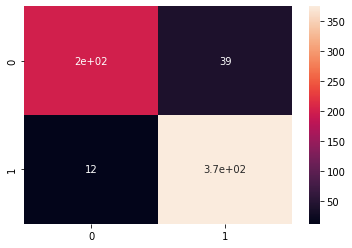

In [41]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [54]:
print(df.image_path.iloc[0].split('/')[-2] + '/' + df.image_path.iloc[0].split('/')[-1])

NORMAL/NORMAL2-IM-0280-0001.jpeg


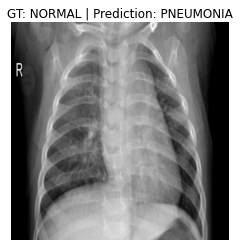

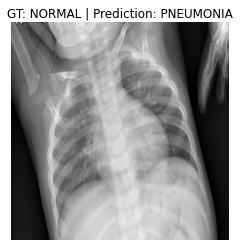

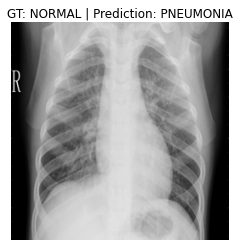

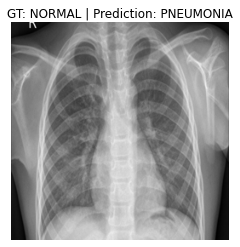

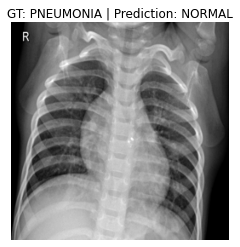

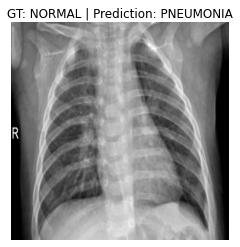

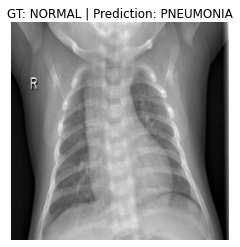

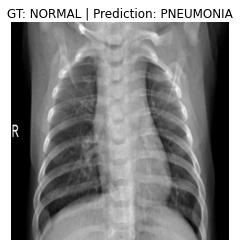

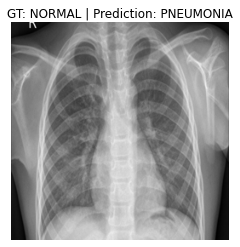

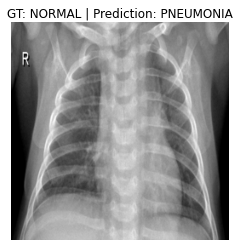

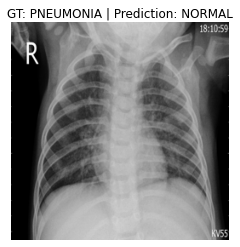

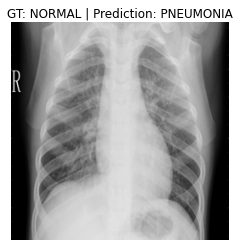

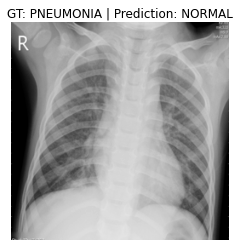

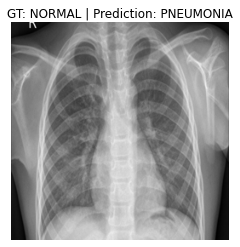

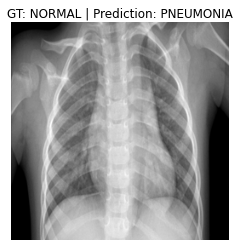

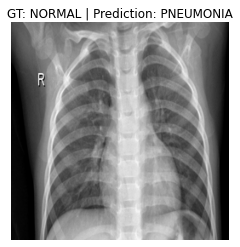

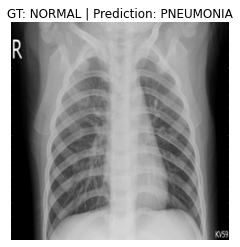

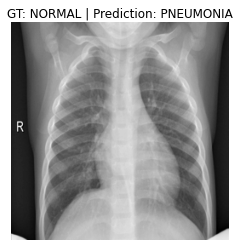

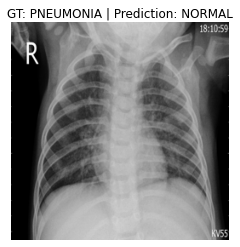

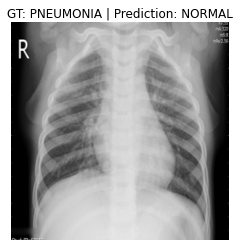

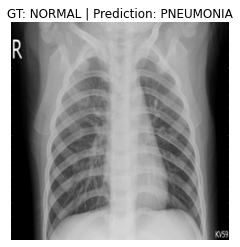

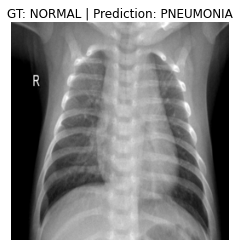

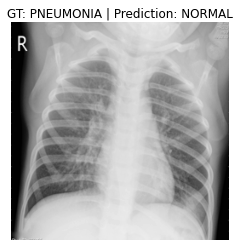

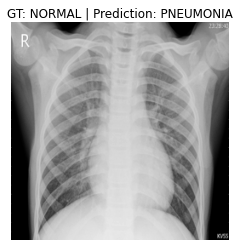

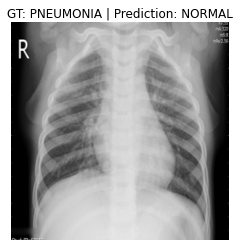

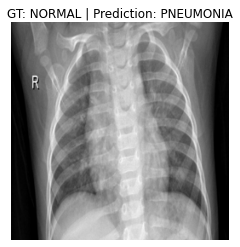

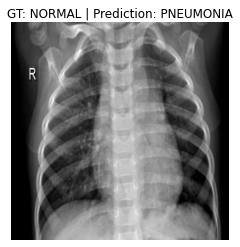

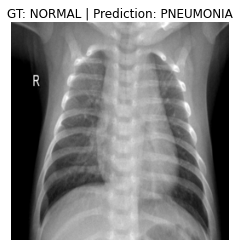

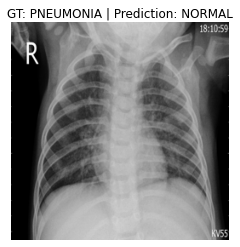

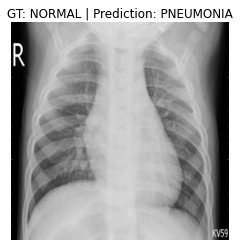

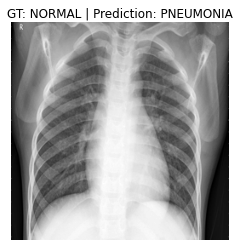

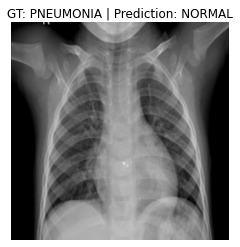

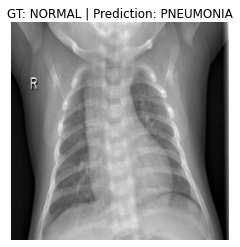

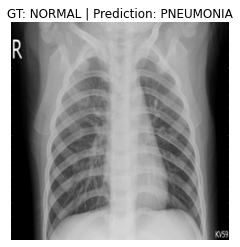

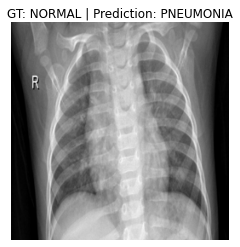

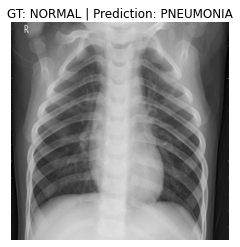

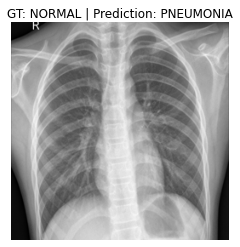

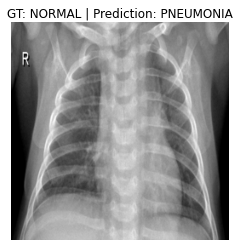

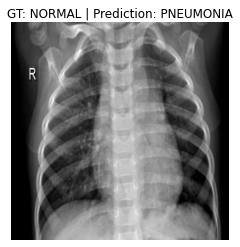

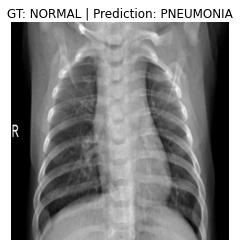

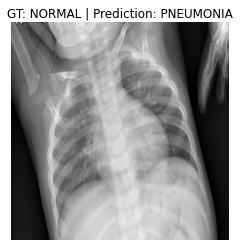

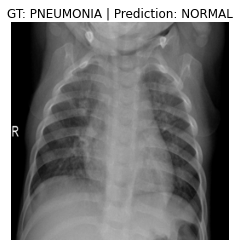

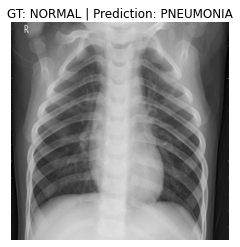

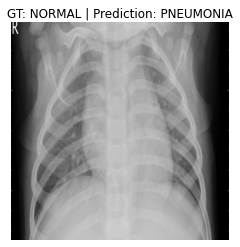

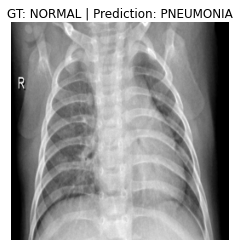

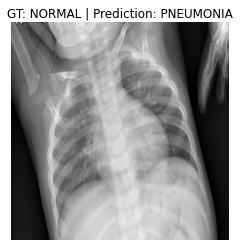

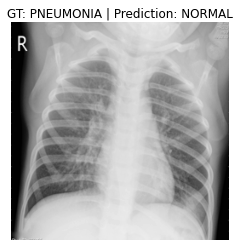

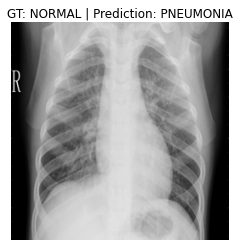

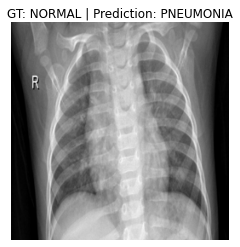

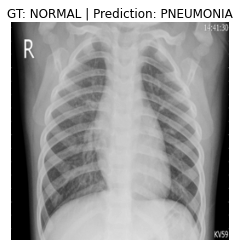

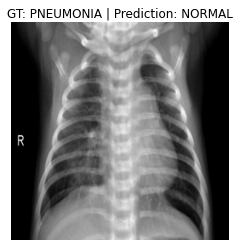

In [55]:
for i in range(len(df)):
    if df.Label.iloc[i] != df.preds.iloc[i]:
        img = Image.open(df.image_path.iloc[i]).convert("L").resize((256, 256))
        img_arr = np.array(img)
        
        plt.imshow(img_arr, cmap="gray")
        plt.title(f"GT: {df.Label.iloc[i]} | Prediction: {df.preds.iloc[i]}")
        plt.axis('off')
        plt.imsave(f"../outputs/images/{df.image_path.iloc[i].split('/')[-2] + '/' + df.image_path.iloc[i].split('/')[-1]}", img_arr, cmap="gray")
        plt.show()